In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
from pandas.io.json import json_normalize

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [12]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
exchange

exchange_id exchange_name
0             0       Unknown
1             1         Fyber
2             2        Smaato
3             3         MoPub
4             4        Nexage
5             7       Rubicon
6             8        Google
7             9        Axonix
8            10      PubMatic
9            11        MobFox
10           14         Opera
11           18     PubNative
12           21      Appodeal
13           22         Tappx
14           24      AdColony
15           29     SmartyAds
16           30    Chartboost
17           33   NexageVideo
18           36        Vungle
19           37         Unity
20           38         Unity
21           39         Unity
22           41      AppLovin
23           44        InMobi
24           45          SoMo
25           46  MobilityWare
26           47     GothamAds
27           48      Vertical
28           49          Kiip
29           50        MailRu
30           52          Epom
31           53    TripleLift
32           54    IronSource
33           55      StartApp
34           56       Algorix
35           57     RhythmOne
36           58       Etermax
37           59       Samsung
38           60     ByteDance
39           99          Test

In [13]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [14]:
start_dt = '2021-05-17'
end_dt = '2021-06-17'

(1) Are we targeting the full eligible audience? Impression overlap between 4 and others. Ignite audiences should be <20%

(2) Metric comparison between experiences

(3) check campaign setup between experiences

(4) How to make optimizations more automated and efficient

In [5]:
df_stats = bigquery_client.query(f"""
select
    sp.bundle as sponsored_bnd
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , r.ad_type
    , r.ad_size
    , r.imp_type
    , r.country
    , r.exchange_id
    , case 
        when ctr_model = 'production' or cr_model = 'production' then 'AP' 
        when ctr_model = 'exploration' or cr_model = 'exploration' then 'media scan'
        else 'ML'
    end as bidder
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , count(case when event_type = 'install' and vta = TRUE then 1 else NULL end)*16 as vt_installs
    , count(case when event_type = 'install' and vta = FALSE then 1 else NULL end)*16 as ct_installs
    , sum(revenue)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16/1000 as bid
from stats.rows r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and ssb_buyer_id = 3549
    and left(r.id,1) = '0'
group by 1,2,3,4,5,6,7,8,9
""").to_dataframe()

In [6]:
df_stats = df_stats.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df_stats = df_stats.set_index('imp_type').join(imp_type.set_index('imp_type_id')).reset_index()
df_stats

index  exchange_id                        sponsored_bnd  \
0          1            1                   br.com.intermedium   
1          1            1                   br.com.intermedium   
2          1            1                  com.twitter.android   
3          1            1              com.king.candycrushsaga   
4          1            1  com.emn8.mobilem8.nativeapp.popeyes   
...      ...          ...                                  ...   
11521     64           30              com.huuuge.casino.texas   
11522     64           30              com.huuuge.casino.texas   
11523     64           30              com.huuuge.casino.texas   
11524     64           30              com.huuuge.casino.texas   
11525     64           30              com.huuuge.casino.texas   

                      ssb_campaign_uuid  \
0      d8f841bb9e6dff2e0012dc857da5f538   
1      d8f841bb9e6dff2e0012dc857da5f538   
2      c3fd3bd696b73e7c4aa683c5457e4ab2   
3      237771ab834d300727c842cadac8d617   
4      1f6365ce92548cbaa4f0c8977e77456d   
...                                 ...   
11521  56d878d2eb31251cc8b4cda9b64519b2   
11522  56d878d2eb31251cc8b4cda9b64519b2   
11523  56d878d2eb31251cc8b4cda9b64519b2   
11524  56d878d2eb31251cc8b4cda9b64519b2   
11525  56d878d2eb31251cc8b4cda9b64519b2   

                                     campaign_name ad_type   ad_size country  \
0                   Android-Banco Inter-Inter-BR-2  banner    320x50      BR   
1                   Android-Banco Inter-Inter-BR-2   inter   320x480      BR   
2                     Android-Twitter-Twitter-US-3  banner    320x50      US   
3            Android-King-Candy Crush-BR-3-Display   inter   480x320      BR   
4                         HMI - Popeyes - US - VZW  banner    320x50      US   
...                                            ...     ...       ...     ...   
11521  Huuuge Games-Billionaire Casino Slots-US-GP   inter  1024x768      US   
11522  Huuuge Games-Billionaire Casino Slots-US-GP   inter   480x320      US   
11523  Huuuge Games-Billionaire Casino Slots-US-GP   inter  768x1024      US   
11524  Huuuge Games-Billionaire Casino Slots-US-GP   inter   320x480      US   
11525  Huuuge Games-Billionaire Casino Slots-US-GP   inter  1024x768      US   

      bidder  impressions  clicks  installs  vt_installs  ct_installs  spend  \
0         AP       486144    2496       256            0            0  128.0   
1         ML        17328    2480       224            0            0  112.0   
2         ML        59296     160         0            0            0    0.0   
3         AP         5936    1232         0            0            0    0.0   
4         AP         1872     320        80            0            0  262.4   
...      ...          ...     ...       ...          ...          ...    ...   
11521     ML         4080     336         0            0            0    0.0   
11522     ML         3072     192         0            0            0    0.0   
11523     ML           32       0         0            0            0    0.0   
11524     ML         2160     128        16            0            0   48.0   
11525     AP         1440      16         0            0            0    0.0   

            cost         bid exchange_name  impression type  
0      62.340295   83.069258         Fyber          display  
1      46.707558   53.860074         Fyber          display  
2       9.224465   11.601313         Fyber          display  
3      12.009918   12.676392         Fyber          display  
4      20.454680  123.475435         Fyber          display  
...          ...         ...           ...              ...  
11521  40.890016   40.866996    Chartboost  rewarded banner  
11522  28.868160   28.835608    Chartboost  rewarded banner  
11523   0.361824    0.361828    Chartboost  rewarded banner  
11524  45.130352   45.113838    Chartboost  rewarded banner  
11525  14.630496   14.631978    Chartboost  rewarded banner  

[11526 rows x 19 columns]

In [11]:
df_stats['campaign_name'] = df_stats['campaign_name'].fillna(0)

exp_1 = [' rt','-rt',' pr','-pr',' retar','-retar','-1','- 1']
exp_2 = [' ua','-ua','-2','- 2']
exp_3 = [' gp','-gp','-3','- 3']
exp_4 = ['true gp','true-gp','true_gp','-4','- 4']
exp_1_uuid = ['33bff90d655b976e9399f1d0b0463d22','eb6dbe92b98fe9a91b00eb06ae37070e','5c2cc36dc709f65250ad09e9926f2020','d8be47c87ebd5047c552f92421103f1a','dad68c13e535c25d96b8a8af78f04033','608ffd6123bdbf7eef34f27889501862','5fef83d15c5b811b424ed58aeb82d0a7']
exp_2_uuid = ['06999d835967801342ac5e0138b30d6b','1f6365ce92548cbaa4f0c8977e77456d','ba0b27afb4dbdaf333f43f8f13b9ee5d','fbc615e1cde9d19c9e8b242169446835','d68c7b0af30354df7c23485a57b8f17e','6e8c92368479165b5464224b5dc43075','3cf6d5969d0fbd8d395b24d0d3cfffae','a2866facee769a34a4a20a3f77bf134a','1a677bdff57ac529612052ffe2c29943','d3b1408721e726a89e34392b8562f61f','b7674540eb94d62830fbc90775d3b95a','46de0fb1f9463e29e66f93ab245d8f0f','a8c01640a10802a1f972029013ad9fc6','38c3a02f8e03b65d410949bcf63a0067','a13d7795071a0b46cf2b0cf31598fa78','2359e9439151f256228cedd5f8780ed4','6c1828f2d2e75b3bda200107fd8c3ec5','729de681656730b0c02ebd707962aec0','dc8a4abf464703b89a87bc19b990deda','8ab98b279f571f61349ab6138d0f51f6','43242a117923679a04b02c58f671f1a8','cfbad4e5cdfcf8e68d0ff1ddb5135586','588e866f5823fe5cc89fce3b0370eff0']
exp_3_uuid = []
exp_4_uuid = ['8f6af55d3b890df1566e59c4bcf13d3c','f1d182a7fabffea0694ae7287aa26c0d']

def classify_campaigns(r):
    if r['ssb_campaign_uuid'] in exp_1_uuid:
        return 1
    elif r['ssb_campaign_uuid'] in exp_2_uuid:
        return 2
    elif r['ssb_campaign_uuid'] in exp_3_uuid:
        return 3
    elif r['ssb_campaign_uuid'] in exp_4_uuid:
        return 4
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_1):
        return 1
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_4):
        return 4
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_3):
        return 3
    elif any(substr in str(r['campaign_name']).lower() for substr in exp_2):
        return 2
    else:
        return -1
    
df_stats['experience_type'] = df_stats.apply(lambda x:classify_campaigns(x), axis = 1)

In [16]:
format_mapping = {'ctr':'{0:.1f}%'
                  ,'ir':'{0:.1f}%'
                  ,'ipm':'{0:.2f}'
                  ,'rpi':'${:,.2f}'
                  ,'cpm':'${:,.2f}'
                  ,'bpm':'${:,.2f}'
                  ,'cost':'${:,.0f}'
                  ,'spend':'${:,.0f}'
                  ,'sov':'{0:.0f}%'
                  ,'imp_sov':'{0:.0f}%'
                  ,'margin':'{0:.0f}%'
                  ,'impressions':'{:,.0f}'
                  ,'clicks':'{:,.0f}'
                  ,'installs':'{:,.0f}'
                 }

def calc_metrics(df, agg_col = np.nan):
    df['ctr'] = df['clicks']/df['impressions']
    df['ir'] = df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['cpm'] = 1000*df['cost']/df['impressions']
    df['bpm'] = 1000*df['bid']/df['impressions']
    try:
        grouped_sum = df['spend'].groupby(agg_col).sum()
    except:
        grouped_sum = df['spend'].sum()
    df['sov'] = df['spend']/grouped_sum
    try:
        grouped_imp_sum = df['impressions'].groupby(agg_col).sum()
    except:
        grouped_imp_sum = df['impressions'].sum()
    df['imp_sov'] = df['impressions']/grouped_imp_sum
    df['margin'] = (df['spend']-df['cost'])/df['spend']
    df.sort_values('sov', ascending = False, inplace = True)
    
def color_format(x, format_str = "{:.2f}", sort_order = ['experience_type', 'sov']):
    x[['ctr','ir','imp_sov','sov','margin']] = 100*x[['ctr','ir','imp_sov','sov','margin']]
    x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
    return x.style.format(format_str).background_gradient(cmap=cm, axis = 0).applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')

In [123]:
by_experience_type = df_stats.groupby('experience_type')['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_experience_type)

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_experience_type[cols], format_mapping, ['spend'])

<ipython-input-123-2e0b432f17a2>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_experience_type = df_stats.groupby('experience_type')['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-122-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.so

In [249]:
exp4_bnds = df_stats.loc[df_stats.experience_type==4, 'sponsored_bnd'].unique()
by_experience_type = df_stats[df_stats.sponsored_bnd.isin(exp4_bnds)].groupby(['sponsored_bnd','experience_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_experience_type)

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_experience_type[cols], format_mapping, ['sponsored_bnd'])

<ipython-input-249-85a823c86d74>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_experience_type = df_stats[df_stats.sponsored_bnd.isin(exp4_bnds)].groupby(['sponsored_bnd','experience_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-122-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [124]:
pvt = df_stats.loc[(df_stats.experience_type == 4)].pivot_table(values = ['spend','installs'], index = 'campaign_name', aggfunc = sum)
pvt.sort_values('spend', ascending = False, inplace = True)
pvt['cpi'] = round(pvt['spend']/pvt['installs'],2)
pvt.style.format('{:.2f}').background_gradient(cm)

In [125]:
by_size = df_stats.groupby('ad_size')['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_size, '*')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
top_sizes = by_size.index.get_level_values(0)[:10].to_list()
color_format(by_size[cols].head(10), format_mapping, ['ad_size','sov'])

<ipython-input-125-bf3bb9d5cfd5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_size = df_stats.groupby('ad_size')['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [126]:
by_imp_experience_type = df_stats.groupby(['impression type','ad_type','experience_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_imp_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','cost','margin']
df_filtered = by_imp_experience_type.loc[by_imp_experience_type.index.get_level_values(0).isin(['display','video']),cols]
color_format(df_filtered, format_mapping, ['impression type', 'ad_type', 'sov'])

<ipython-input-126-3994aa4f74d8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_imp_experience_type = df_stats.groupby(['impression type','ad_type','experience_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()


In [127]:
by_imp_experience_type = df_stats.groupby(['experience_type','impression type','ad_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_imp_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_imp_experience_type[cols], format_mapping, ['experience_type', 'spend'])

<ipython-input-127-f8b07eb356b3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_imp_experience_type = df_stats.groupby(['experience_type','impression type','ad_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-122-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [128]:
by_size_experience_type = df_stats.groupby(['impression type', 'ad_size','experience_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_size_experience_type, ['experience_type'])

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_size_experience_type.loc[by_size_experience_type.index.get_level_values(1).isin(top_sizes), cols], format_mapping, ['impression type', 'ad_size', 'spend'])

<ipython-input-128-1639678e5a72>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_size_experience_type = df_stats.groupby(['impression type', 'ad_size','experience_type'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()


In [129]:
by_exchange = df_stats.groupby(['exchange_name'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_exchange, '*')

top_exchanges = by_exchange.index[:5]
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_exchange.loc[:,cols].head(10), format_mapping, ['spend'])

<ipython-input-129-c627dd6ffa4f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_exchange = df_stats.groupby(['exchange_name'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()


In [130]:
by_exchange_experience_type = df_stats.groupby(['experience_type','exchange_name'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_exchange_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_exchange_experience_type.loc[by_exchange_experience_type.index.get_level_values(1).isin(top_exchanges), cols], format_mapping, ['experience_type', 'spend'])

<ipython-input-130-900f2c4887a9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_exchange_experience_type = df_stats.groupby(['experience_type','exchange_name'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()


In [176]:
by_exchange_experience_type = df_stats.groupby(['experience_type','exchange_name','ad_size'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_exchange_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
df_filtered = by_exchange_experience_type.loc[(by_exchange_experience_type.index.get_level_values(0) == 4) & (by_exchange_experience_type.index.get_level_values(1).isin(top_exchanges)) & (by_exchange_experience_type.index.get_level_values(2).isin(top_sizes)), cols]
color_format(df_filtered, format_mapping, ['experience_type', 'spend'])

<ipython-input-176-031bf3807559>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_exchange_experience_type = df_stats.groupby(['experience_type','exchange_name','ad_size'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [132]:
top_countries = df_stats.groupby('country')['spend'].sum().sort_values(ascending = False).index.to_list()[:8]
by_country_experience_type = df_stats.groupby(['experience_type','country'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_country_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_country_experience_type.loc[by_country_experience_type.index.get_level_values(1).isin(top_countries), cols], format_mapping, ['experience_type', 'spend'])

<ipython-input-132-e3c0fc016a8d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_country_experience_type = df_stats.groupby(['experience_type','country'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()


In [133]:
df_stats.loc[df_stats.experience_type == -1, ['campaign_name', 'ssb_campaign_uuid']].drop_duplicates()

Empty DataFrame
Columns: [campaign_name, ssb_campaign_uuid]
Index: []

In [20]:
df_campaigns = bigquery_client.query(f"""
select
    name as campaign_name
    , *
from metadata.dt_campaigns c
""").to_dataframe()

In [134]:
json_struct = df_campaigns['extra_data'].apply(json.loads)
df_campaigns_flat = pd.io.json.json_normalize(json_struct) 
df_campaigns_joined = df_campaigns.join(df_campaigns_flat)
df_campaigns_joined.drop(['extra_data'], axis = 1, inplace = True)
df_campaigns_joined.rename(columns = {'uuid':'ssb_campaign_uuid'}, inplace = True)
df_campaigns_joined['experience_type'] = df_campaigns_joined.apply(lambda x:classify_campaigns(x), axis = 1)
df_campaigns_joined.columns[:50]

<ipython-input-134-ff624ec87c9c>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_campaigns_flat = pd.io.json.json_normalize(json_struct)


Index(['campaign_name', 'updated_at', 'name', 'created_at', 'end_at',
       'ssb_campaign_uuid', 'country', 'form_factor', 'vertical_tag', 'status',
       'sponsored_app_id', 'platform', 'enabled', 'offer_id', 'start_at', 'id',
       'max_views', 'custom_revenue', 'ip_ranges', 'scan_restarted_at',
       'fcap_min_impressions_interval', 'fcap_consecutive_impressions',
       'realloc_scan_budget', 'auto_pilot', 'auto_pilot_level',
       'media_plan_daily_budget', 'reject_no_consent', 'use_dlp',
       'block_coppa', 'show_for_converted', 'bundle_retarget', 'ifa_presence',
       'use_external_browser', 'model_optimize', 'boost_enabled',
       'connectivity', 'maxmind_mask', 'media_plan_pacing_mode',
       'media_scan_pacing_mode', 'impression_attribution_enabled',
       'override_auto_actions', 'boost_max_multiplier',
       'override_account_blacklists', 'viewability_mode',
       'add_click_on_video_complete', 'smart_dnt', 'dnt_cap_boost',
       'creatives_ab_enabled', 'skad_

In [135]:
df_stats_campaign = df_stats.pivot_table(values = ['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'], index = ['ssb_campaign_uuid','country','experience_type'], aggfunc = np.sum).reset_index()

df_stats_campaign = df_stats_campaign.set_index(['ssb_campaign_uuid','country','experience_type']).join(df_campaigns_joined.set_index(['ssb_campaign_uuid','country','experience_type'])).reset_index()

by_country_experience_type = df_stats_campaign.groupby(['experience_type','country'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid','media_plan_daily_budget'].sum()
calc_metrics(by_country_experience_type, 'experience_type')

by_country_experience_type['daily_spend'] = by_country_experience_type['spend']/(pd.to_datetime(end_dt) - pd.to_datetime(start_dt)).days
cols = ['impressions','imp_sov','spend','sov','media_plan_daily_budget']
pivot = by_country_experience_type.loc[by_country_experience_type.index.get_level_values(1).isin(top_countries), cols]
pivot.sort_values(['experience_type', 'spend'], ascending = False, inplace = True)
pivot.style.format({'impressions':'{:,.0f}', 'imp_sov':'{:,.0f}%', 'spend':'${:,.0f}', 'daily_spend':'${:,.0f}', 'media_plan_daily_budget':'${:,.0f}'})


<ipython-input-135-4a51d989ae90>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_country_experience_type = df_stats_campaign.groupby(['experience_type','country'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid','media_plan_daily_budget'].sum()


In [23]:
df_fyber = bigquery_client.query(f"""
select
    case when ssb_buyer_id = 3549 then 'DT' else 'Other' end as buyer
    , case when aud.tid is not null then TRUE else FALSE end as ignite_eligible
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows r
left join (
    select tid
    from audiences.dt_aud
    group by 1
) aud 
    on r.tid = aud.tid
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(r.id,1) = '0'
    and exchange_id = 1
group by 1,2
""").to_dataframe()
df_fyber['sov'] = 100*df_fyber['cost']/df_fyber['cost'].sum()
df_fyber.sort_values('cost', ascending = False).style.format({'cost':'${:,.0f}', 'sov':'{:.0f}%'})

In [24]:
df_fyber.style.format({'cost':'${:,.0f}', 'sov':'{:.0f}%'})

In [136]:
by_bidder_experience_type = df_stats.groupby(['experience_type','bidder'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_bidder_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_bidder_experience_type[cols], format_mapping, ['experience_type', 'spend'])

<ipython-input-136-d18055e08bf8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_bidder_experience_type = df_stats.groupby(['experience_type','bidder'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-122-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [137]:
by_bidder_experience_type = df_stats[~df_stats.campaign_name.str.contains('Twitter')].groupby(['experience_type','bidder'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_bidder_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_bidder_experience_type[cols], format_mapping, ['experience_type', 'spend'])

<ipython-input-137-9ba38f42cf26>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_bidder_experience_type = df_stats[~df_stats.campaign_name.str.contains('Twitter')].groupby(['experience_type','bidder'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
<ipython-input-122-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)


In [138]:
by_bidder_experience_type = df_stats[df_stats.experience_type == 4].groupby(['campaign_name','bidder'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
calc_metrics(by_bidder_experience_type, 'experience_type')

cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','sov','margin']
color_format(by_bidder_experience_type[cols], format_mapping, ['bidder', 'spend'])

<ipython-input-138-36f76276733e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_bidder_experience_type = df_stats[df_stats.experience_type == 4].groupby(['campaign_name','bidder'])['impressions','clicks','installs','vt_installs','ct_installs','spend','cost','bid'].sum()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-122-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [139]:
df_stats.pivot_table(values = ['impressions', 'ssb_campaign_uuid'], index = ['experience_type'], columns = 'bidder', aggfunc = {'impressions':sum, 'ssb_campaign_uuid':lambda x:len(x.unique())})

impressions            ssb_campaign_uuid    
bidder                   AP         ML                AP  ML
experience_type                                             
1                  14082400   15006640                19  19
2                 100351392  199560496                80  64
3                 143896416  357392368                40  39
4                 388458688  138186432                47  24

In [140]:
pvt = df_stats.loc[(df_stats.experience_type == 4)].pivot_table(values = 'impressions', index = 'campaign_name', columns = 'bidder', aggfunc = sum)
pvt.sort_values(['ML', 'AP'], ascending = False, inplace = True)
pvt

bidder                                              AP          ML
campaign_name                                                     
Pandora - Pandora - US - iOS                33301728.0  42442912.0
Twitter - Twitter - BR - True GP                   NaN  31934384.0
Particle Media-News Break-US-iOS             4969456.0  17720832.0
Android-Twitter-Twitter-ES-4                17029216.0   9915280.0
Android-Twitter-Twitter-FR-4                35737344.0   9897136.0
Android-Twitter-Twitter-IT-4                32306752.0   9158512.0
Android-iFood BR-iFood-BR-4                  3548624.0   2901376.0
Pandora - Pandora - US - True GP             1184832.0   2719312.0
Android-Twitter-Twitter-PH-4                 9216608.0   2699648.0
Android-Twitter-Twitter-DE-4                29230912.0   2381056.0
Android-Twitter-Twitter-TH-4                11929216.0   1796832.0
Android-Twitter-Twitter-EG-4                36841488.0   1594608.0
Android-Door Dash-Door Dash-US- 4           11071792.0    610272.0
Android-Twitter-Twitter-UK-4                16912240.0    572192.0
Android-Twitter-Twitter-CL-4                 5943824.0    479328.0
Android-Twitter-Twitter-MX-4                 4382880.0    426928.0
Android-Twitter-Twitter-ID-4                16835792.0    327344.0
TikTok - TikTok - MX - True GP                723184.0    220592.0
Android-Twitter-Twitter-AR-4                 3419536.0    148832.0
Android-Twitter-Twitter-VN-4                 5860160.0    107664.0
Android-Opera Norway As-Opera News-FR-4     18149312.0     79664.0
Android-Klarna-Klarna-US-4                  11617680.0     40176.0
Android-King-Candy Crush-US-4-Video           592672.0      9152.0
Android-King-Candy Crush-BR-4-Video           387296.0      2400.0
Android-Opera Norway As-Opera News-DE-4     18749808.0         NaN
Android-Twitter-Twitter-NL-4                10639792.0         NaN
Android-Twitter-Twitter-BE-4                 7518160.0         NaN
Android-Twitter-Twitter-US-4                 7114928.0         NaN
Android-Twitter-Twitter-CA-4                 5056448.0         NaN
Android-Twitter-Twitter-AU-4                 4653376.0         NaN
Android-Rovio-Angry Birds Dream Blast-US-4   4571648.0         NaN
Android-Twitter-Twitter-KR-4                 2991808.0         NaN
Android-Twitter-Twitter-JP-4                 2245104.0         NaN
Android-Twitter-Twitter-PT-4                 1821232.0         NaN
Android-Twitter-Twitter-SA-4                 1616352.0         NaN
Android-Twitter-Twitter-SG-4                 1386416.0         NaN
Android-King-Candy Crush-US-4-Display        1344768.0         NaN
Position Mobile-WeatherHome-US-4             1334384.0         NaN
Android-Twitter-Twitter-IE-4                 1333344.0         NaN
Android-Twitter-Twitter-MY-4                 1269728.0         NaN
Android-Intuit-Mint-US-4                      838528.0         NaN
HMI-Popeyes-US-4                              818992.0         NaN
Android-Twitter-Twitter-TR-4                  741360.0         NaN
Huuuge Games-Billionaire Casino Slots-US-4    536368.0         NaN
Android-King-Candy Crush-BR-4-Display         477568.0         NaN
Android-Wish-Wish-US-4                        108416.0         NaN
Android-Playtika-Slotomania-US-4               81952.0         NaN
Beach Bum-Spade Royale-US-4                    15664.0         NaN

In [30]:
df_campaigns = bigquery_client.query(f"""
select
    name as campaign_name
    , *
from metadata.dt_campaigns c
""").to_dataframe()

In [141]:
json_struct = df_campaigns['extra_data'].apply(json.loads)
df_campaigns_flat = pd.io.json.json_normalize(json_struct) 
df_campaigns_joined = df_campaigns.join(df_campaigns_flat)
df_campaigns_joined.drop(['extra_data'], axis = 1, inplace = True)
df_campaigns_joined.rename(columns = {'uuid':'ssb_campaign_uuid'}, inplace = True)
df_campaigns_joined['experience_type'] = df_campaigns_joined.apply(lambda x:classify_campaigns(x), axis = 1)
df_campaigns_joined.columns[:50]

<ipython-input-141-ff624ec87c9c>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_campaigns_flat = pd.io.json.json_normalize(json_struct)


Index(['campaign_name', 'updated_at', 'name', 'created_at', 'end_at',
       'ssb_campaign_uuid', 'country', 'form_factor', 'vertical_tag', 'status',
       'sponsored_app_id', 'platform', 'enabled', 'offer_id', 'start_at', 'id',
       'max_views', 'custom_revenue', 'ip_ranges', 'scan_restarted_at',
       'fcap_min_impressions_interval', 'fcap_consecutive_impressions',
       'realloc_scan_budget', 'auto_pilot', 'auto_pilot_level',
       'media_plan_daily_budget', 'reject_no_consent', 'use_dlp',
       'block_coppa', 'show_for_converted', 'bundle_retarget', 'ifa_presence',
       'use_external_browser', 'model_optimize', 'boost_enabled',
       'connectivity', 'maxmind_mask', 'media_plan_pacing_mode',
       'media_scan_pacing_mode', 'impression_attribution_enabled',
       'override_auto_actions', 'boost_max_multiplier',
       'override_account_blacklists', 'viewability_mode',
       'add_click_on_video_complete', 'smart_dnt', 'dnt_cap_boost',
       'creatives_ab_enabled', 'skad_

In [142]:
df_stats_joined = df_stats.set_index(['ssb_campaign_uuid', 'campaign_name', 'experience_type']).join(df_campaigns_joined.set_index(['ssb_campaign_uuid', 'campaign_name', 'experience_type']), rsuffix='_joined').reset_index()
pd.DataFrame([df_stats_joined.isna().sum(), df_stats_joined.count()], index = ['na_cells', 'total']).iloc[:, 18:]

exchange_name  impression type  updated_at   name  created_at  \
na_cells              0                0           0      0           0   
total             11526            11526       11526  11526       11526   

          end_at  country_joined  form_factor  vertical_tag  status  ...  \
na_cells   11526               0            0            61       0  ...   
total          0           11526        11526         11465   11526  ...   

          media_plan_max_budget  online_push_started_at  online_push_ended_at  \
na_cells                  11526                   11152                 11152   
total                         0                     374                   374   

          store_on_device  tids_campaign_bundles  tids_campaign_uuids  \
na_cells            11526                  11465                11526   
total                   0                     61                    0   

          tids_excluded_events  mp_daily_clicks  \
na_cells                 11526            11467   
total                        0               59   

          dnt_plan_daily_budget_max_perct  non_dnt_plan_daily_budget_max_perct  
na_cells                            11465                                11451  
total                                  61                                   75  

[2 rows x 201 columns]

In [143]:
i = 'media_plan_pacing_mode'
pivot = df_stats_joined.pivot_table(values = 'impressions', index = i, columns = 'experience_type', aggfunc = sum, margins = True)
sov = pivot.div(pivot.iloc[-1], axis = 1)[:-1]
sov.sort_values(4, ascending = False, inplace = True)
(100*sov).style.format('{:.0f}%')

In [144]:
i = 'media_plan_pacing_mode'
pivot = df_stats_joined.pivot_table(values = 'ssb_campaign_uuid', index = i, columns = 'experience_type', aggfunc = lambda x:len(x.unique()), margins = True)
pivot.sort_values(4, ascending = False, inplace = True)
pivot.head(10)

experience_type            1     2     3     4  All
media_plan_pacing_mode                             
All                     22.0  86.0  45.0  48.0  201
1                       17.0  50.0  40.0  44.0  151
2                        5.0  35.0   4.0   4.0   48
0                        NaN   1.0   1.0   NaN    2

In [145]:
i = 'model_optimize'
pivot = df_stats_joined.pivot_table(values = 'impressions', index = i, columns = 'experience_type', aggfunc = sum, margins = True)
sov = pivot.div(pivot.iloc[-1], axis = 1).iloc[:-1]
(100*sov).style.format('{:.0f}%').background_gradient(cmap=cm, axis=0).applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')

In [146]:
i = 'model_optimize'
pivot = df_stats_joined.pivot_table(values = 'spend', index = i, columns = 'experience_type', aggfunc = sum, margins = True)
sov = pivot.div(pivot.iloc[-1], axis = 1).iloc[:-1]
(100*sov).style.format('{:.0f}%').background_gradient(cmap=cm, axis=0).applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')

In [147]:
i = 'model_optimize'
pivot = df_stats_joined.pivot_table(values = 'ssb_campaign_uuid', index = i, columns = 'experience_type', aggfunc = lambda x:len(x.unique()), margins = True)
pivot

experience_type     1     2     3     4  All
model_optimize                              
0                 NaN   3.0   1.0   NaN    4
5                 1.0   NaN   NaN   NaN    1
10                1.0   1.0   2.0   NaN    4
20                NaN   2.0   NaN   1.0    3
25                NaN   1.0   NaN   NaN    1
30               10.0  34.0   9.0  31.0   84
40                2.0   NaN   NaN   NaN    2
50                2.0   4.0   2.0   5.0   13
60                1.0   1.0   3.0   1.0    6
70                1.0   1.0   1.0   1.0    4
80                NaN   1.0   NaN   1.0    2
90                1.0  26.0  16.0   6.0   49
100               3.0  12.0  11.0   2.0   28
All              22.0  86.0  45.0  48.0  201

In [148]:
i = 'ifa_presence'
pivot = df_stats_joined.pivot_table(values = 'impressions', index = i, columns = 'experience_type', aggfunc = sum, margins = True)
sov = pivot.div(pivot.iloc[-1], axis = 1)[:-1]
(100*sov).style.format('{:.0f}%').applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')

In [149]:
i = 'ifa_presence'
pivot = df_stats_joined.pivot_table(values = 'ssb_campaign_uuid', index = i, columns = 'experience_type', aggfunc = lambda x:len(x.unique()), margins = True)
pivot
# 0 = None, 2 = Present

experience_type   1   2   3   4  All
ifa_presence                        
0.0              18  65  26  20  129
2.0               2  16  17  16   51
All              20  81  43  36  180

In [150]:
df_stats_joined[['campaign_name','ifa_presence']].drop_duplicates().tail(30)

campaign_name  ifa_presence
9655                              Android-Wish-Wish-US-4           0.0
9691                            Android-Intuit-Mint-US-3           0.0
9725          Android-Rovio-Angry Birds Dream Blast-US-4           2.0
9753                 Android-King-Candy Crush-BR-2-Video           0.0
9794           Android-Crazy Maple Studios-Chapters-US-2           0.0
9825                 Rovio-Angry Birds Dream Blast-US-GP           2.0
9889                         Android-iFood BR-iFood-BR-2           0.0
9985              Android-Position Mobile-BibleHome-US-2           0.0
10079      Particle Media - News Break - US - Cricket PR           0.0
10163            Android-Opera Norway As-Opera News-DE-4           0.0
10193                       Android-Twitter-Twitter-ID-4           0.0
10342                       Android-Twitter-Twitter-MX-3           0.0
10492            Android-Opera Norway As-Opera News-FR-4           0.0
10527             SmartNews_Cricket_SingleTap_All_CPI_NA           NaN
10634             Blind Ferret - Rewarded Play - US - UA           0.0
10662                       Android-Twitter-Twitter-US-2           0.0
10718                       Android-Twitter-Twitter-ES-4           NaN
10823                       Beach Bum-Spade Royale-US-GP           0.0
10893  Particle Media - News Break - US - VZW PR - Video           0.0
10933                    Skillz - Pool Pay Day - US - UA           0.0
11013                   Particle Media-News Break-US-iOS           NaN
11074                   Position Mobile-WeatherHome-US-4           2.0
11129                Android-King-Candy Crush-BR-3-Video           0.0
11161                       Android-Twitter-Twitter-MX-4           2.0
11226      Android-SmartNews Inc-SmartNews-US-Tracfone-3           0.0
11279                     PlaySimple-Word Trip-US-VZW-T1           0.0
11353                       Android-Twitter-Twitter-PT-4           2.0
11386            Skillz - Blackout Blitz - US - UA - VZW           0.0
11408      Particle Media - News Break - US - Cricket UA           0.0
11508                           Android-Ripio-Ripio-AR-3           0.0

In [152]:
df_offers = bigquery_client.query(f"""
select
    c.name as campaign_name
    , c.uuid
    , o.*
from metadata.dt_offers o
left join metadata.dt_campaigns c
    on o.id = c.offer_id
""").to_dataframe()

In [154]:
json_struct = df_offers['extra_data'].apply(json.loads)
df_offers_flat = pd.io.json.json_normalize(json_struct) 
df_offers_joined = df_offers.join(df_offers_flat)
df_offers_joined.drop(['extra_data'], axis = 1, inplace = True)
df_offers_joined.rename(columns = {'uuid':'ssb_campaign_uuid'}, inplace = True)
df_offers_joined['experience_type'] = df_offers_joined.apply(lambda x:classify_campaigns(x), axis = 1)
df_offers_joined.columns[:50]

<ipython-input-154-f9bc403cf76f>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_offers_flat = pd.io.json.json_normalize(json_struct)


Index(['campaign_name', 'ssb_campaign_uuid', 'package_name',
       'user_defined_type', 'type', 'affiliate_network', 'cpi', 'updated_at',
       'form_factor', 'country', 'status', 'platform', 'name', 'created_at',
       'sponsored_app_app_id', 'unique_offer', 'id', 'click_url',
       'external_click_url', 'landing_url', 'iab_category', 'dt_enabled',
       'user_defined_optimization_type', 'optimization_cpc_goal',
       'impression_pixel_url', 'impression_pixel_urls', 'extra_advertisers',
       'publisher', 'status_updated_at', 'store_category', 'target_user_type',
       'enable_s2s_click', 'extra_bcats', 'google_product_categories',
       'google_sensitive_categories', 'click_url_redirects', 'vertical_tag',
       'last_activated_at', 'enable_imp_dedup', 'custom_click_url',
       'org_landing_url', 'auto_pilot_cpi_factor', 'optimization_action_name',
       'optimization_cpa_goal', 'optimization_action_num_days',
       'auto_pilot_cpa_factor', 'geoedge_excluded_trigger_types

In [157]:
export = df_offers_joined[['publisher', 'ssb_campaign_uuid', 'name', 'cpi', 'created_at', 'auto_pilot_cpi_factor', 'cpi', 'impression_pixel_urls', 'custom_click_url']]
export = export.set_index('ssb_campaign_uuid').join(df_campaigns_joined[['campaign_name','max_views','media_plan_pacing_mode', 'ssb_campaign_uuid']].set_index('ssb_campaign_uuid'))
export.reset_index().sort_values('created_at').to_csv(f'~/Downloads/campaign_metadata_export_{end_dt}.csv')

In [158]:
df_offers_joined = df_stats.set_index(['campaign_name', 'experience_type']).join(df_offers_joined.set_index(['campaign_name', 'experience_type']), lsuffix = '_stat').reset_index()


(0.0, 4.0)

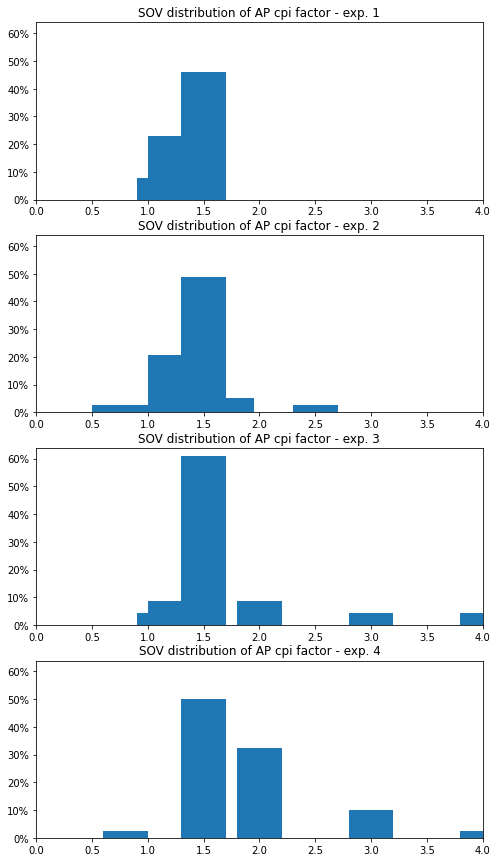

In [160]:
i = 'auto_pilot_cpi_factor'
pivot = df_offers_joined.pivot_table(values = 'ssb_campaign_uuid', index = i, columns = 'experience_type', aggfunc = lambda x:len(x.unique()), margins = True)
sov = pivot.div(pivot.iloc[-1], axis = 1)[:-1]

fig, ax = plt.subplots(4,1, figsize = (8,15), sharey = True)
ax[0].bar(sov.index, sov[1], width = .4)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].set_title('SOV distribution of AP cpi factor - exp. 1')
ax[0].set_xlim(0,4)
ax[1].bar(sov.index, sov[2], width = .4)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1].set_title('SOV distribution of AP cpi factor - exp. 2')
ax[1].set_xlim(0,4)
ax[2].bar(sov.index, sov[3], width = .4)
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[2].set_title('SOV distribution of AP cpi factor - exp. 3')
ax[2].set_xlim(0,4)
ax[3].bar(sov.index, sov[4], width = .4)
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[3].set_title('SOV distribution of AP cpi factor - exp. 4')
ax[3].set_xlim(0,4)

In [161]:
i = 'dt_enabled'
pivot = df_offers_joined.pivot_table(values = 'campaign_name', index = i, columns = 'experience_type', aggfunc = lambda x:len(x.unique()), margins = True)
pivot

experience_type     1     2     3     4  All
dt_enabled                                  
False             2.0   1.0   3.0  48.0   54
True             20.0  85.0  42.0   NaN  147
All              22.0  86.0  45.0  48.0  201

In [47]:
df_overlap = bigquery_client.query(f"""
select
    tid
    , sp.bundle as sponsored_bnd
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , r.dt_eligible
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(revenue) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
from stats.rows r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and ssb_buyer_id = 3549
    and event_type in ('clear','click','install')
    and right(r.tid,1) = '0'
group by 1,2,3,4,5
""").to_dataframe()
df_overlap
# split by dt_eligible

tid               sponsored_bnd  \
0         88b9eaab044a2bfddf60a38e934f6a70     com.king.candycrushsaga   
1         993cf9f45c9430ac2f817a817eb1ad70      com.home.weather.radar   
2         b1ea0cc62491b4d8b48601573fca8160  jp.gocro.smartnews.android   
3         bfc33c8d079e05232bc0ea1c13753e50  jp.gocro.smartnews.android   
4         6e8954d503a0733df2e3af4def732400            com.creditsesame   
...                                    ...                         ...   
23266064  c6200510d63c05425396e553b30767e0  com.particlenews.newsbreak   
23266065  60bfbb970ef828cde42339373a59b230  com.particlenews.newsbreak   
23266066  1188349e576f83abef9e2a73f3ef7370  com.particlenews.newsbreak   
23266067  9469d13ea0ce9fbf6a2f7952d4791080  com.particlenews.newsbreak   
23266068  72d3e6184ad0b31dde5a45957c19f790  com.particlenews.newsbreak   

                         ssb_campaign_uuid  \
0         f62e397472a0cf3e7633bae892319d97   
1         f26adcfdd8b0a653e86528af46961c1d   
2         faed52a49eb4914b698a209027f1a00f   
3         099a5d47e9bf3796c1b9ca5c5f4bc264   
4         d8ee55bb6a1ac49f92211ed4a9313f85   
...                                    ...   
23266064  16d935fca4ea8b4dffa296ba147ec7df   
23266065  16d935fca4ea8b4dffa296ba147ec7df   
23266066  16d935fca4ea8b4dffa296ba147ec7df   
23266067  16d935fca4ea8b4dffa296ba147ec7df   
23266068  16d935fca4ea8b4dffa296ba147ec7df   

                                              campaign_name  dt_eligible  \
0                       Android-King-Candy Crush-BR-3-Video          NaN   
1                          Position Mobile-WeatherHome-US-4          NaN   
2             Android-SmartNews Inc-SmartNews-US-Tracfone-3          NaN   
3                   Android-SmartNews Inc-SmartNews-US-VZ-2          NaN   
4                   Credit Sesame - Credit Sesame - UA – US          NaN   
...                                                     ...          ...   
23266064  Particle Media – News Break – US – All – GP - ...          NaN   
23266065  Particle Media – News Break – US – All – GP - ...          NaN   
23266066  Particle Media – News Break – US – All – GP - ...          0.0   
23266067  Particle Media – News Break – US – All – GP - ...          NaN   
23266068  Particle Media – News Break – US – All – GP - ...          NaN   

          impressions  clicks  installs  spend      cost       bid  
0                   1       0         0    0.0  0.000482  0.000482  
1                   1       0         0    0.0  0.003863  0.003998  
2                   1       0         0    0.0  0.000180  0.000187  
3                   1       0         0    0.0  0.000868  0.000868  
4                   1       0         0    0.0  0.013074  0.013074  
...               ...     ...       ...    ...       ...       ...  
23266064            5       0         0    0.0  0.011962  0.011962  
23266065            1       0         0    0.0  0.000740  0.000740  
23266066            0       1         0    0.0  0.000000  0.000000  
23266067            2       0         0    0.0  0.002835  0.002799  
23266068            9       0         0    0.0  0.014000  0.013955  

[23266069 rows x 11 columns]

In [162]:
df_overlap['experience_type'] = df_overlap.apply(lambda x:classify_campaigns(x), axis = 1)

In [163]:
pivot = df_overlap.fillna(-1).groupby('dt_eligible')['impressions','clicks','installs','spend'].sum()
pivot['click_sov'] = 100*pivot['clicks']/pivot['clicks'].sum()
pivot.style.format({'clicks':'{:,.0f}','installs':'{:,.0f}','spend':'${:,.0f}','spend_sov':'{:.0f}%','click_sov':'{:.0f}%'})

<ipython-input-163-00b6eaf2659b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = df_overlap.fillna(-1).groupby('dt_eligible')['impressions','clicks','installs','spend'].sum()


In [164]:
df_overlap['dt_eligible'] = df_overlap['dt_eligible'].fillna(-1)
pivot = 16*df_overlap.pivot_table(values = ['clicks','installs','spend'], index = ['experience_type','dt_eligible'], aggfunc = np.sum)
pivot['spend_sov'] = round(100*pivot['spend']/pivot['spend'].groupby('experience_type').transform('sum'),2)
pivot['click_sov'] = round(100*pivot['clicks']/pivot['clicks'].groupby('experience_type').transform('sum'),2)
pivot.style.format({'clicks':'{:,.0f}','installs':'{:,.0f}','spend':'${:,.0f}','spend_sov':'{:.0f}%','click_sov':'{:.0f}%'})

In [165]:
filters = (df_overlap.experience_type.isin([1,2]))
pivot = 16*df_overlap[filters].pivot_table(values = ['clicks', 'installs','spend'], index = ['campaign_name','ssb_campaign_uuid'], columns = 'dt_eligible', aggfunc = np.sum, margins = True)
pivot[(pivot[('clicks',-1)]>0)].style.format('{:,.0f}')

In [166]:
false_positives = pivot[(pivot[('clicks',-1)]>0)].index.get_level_values(1).to_list()[:-1]
df_overlap['experience_type'] = np.where(df_overlap.ssb_campaign_uuid.isin(false_positives),-1, df_overlap.experience_type)
pivot = 16*df_overlap.pivot_table(values = ['clicks'], index = ['experience_type','dt_eligible'], aggfunc = np.sum)
pivot['click_sov'] = round(100*pivot['clicks']/pivot['clicks'].groupby('experience_type').transform('sum'),2)
pivot.style.format({'clicks':'{:,.0f}','click_sov':'{:.0f}%'})

In [167]:
filters = (df_overlap.experience_type.isin([1,2]))
pivot = 16*df_overlap[filters].pivot_table(values = 'clicks', index = ['campaign_name','ssb_campaign_uuid'], columns = 'dt_eligible', aggfunc = np.sum, margins = True)
pivot['pct_ineligible'] = 100*pivot[0]/pivot['All']
pivot[[0,1,'pct_ineligible']].sort_values(0, ascending = False).head(20).style.format('{:,.0f}').format('{:,.0f}%','pct_ineligible').background_gradient(cmap = cm, axis=0, subset='pct_ineligible')

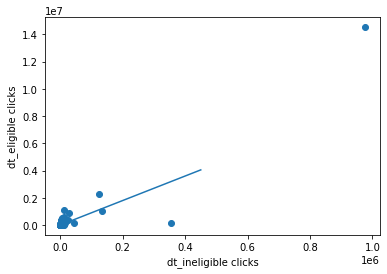

In [168]:
# pivot.drop('All', axis = 0, inplace = True)
plt.scatter(pivot[[0]],pivot[[1]])
plt.xlabel('dt_ineligible clicks')
plt.ylabel('dt_eligible clicks')
x_range = np.arange(0,450000)
y_range = x_range*9
plt.plot(pd.DataFrame(y_range, index = x_range))


In [169]:
overlap_1 = df_overlap[df_overlap.experience_type == 1].groupby(['tid','sponsored_bnd'])['impressions','clicks','installs','spend','cost'].sum()
overlap_2 = df_overlap[df_overlap.experience_type == 2].groupby(['tid','sponsored_bnd'])['impressions','clicks','installs','spend','cost'].sum()
overlap_3 = df_overlap[df_overlap.experience_type == 3].groupby(['tid','sponsored_bnd'])['impressions','clicks','installs','spend','cost'].sum()
overlap_4 = df_overlap[(df_overlap.experience_type == 4) & (df_overlap.sponsored_bnd != 'com.twitter.android')].groupby(['tid','sponsored_bnd'])['impressions','clicks','installs','spend','cost'].sum()

join_4_1 = overlap_4.join(overlap_1, lsuffix = '_4', rsuffix = '_1')
join_4_2 = overlap_4.join(overlap_2, lsuffix = '_4', rsuffix = '_2')
join_4_3 = overlap_4.join(overlap_3, lsuffix = '_4', rsuffix = '_3')
join_3_1 = overlap_3.join(overlap_1, lsuffix = '_3', rsuffix = '_1')
join_3_2 = overlap_3.join(overlap_2, lsuffix = '_3', rsuffix = '_2')
join_3_4 = overlap_3.join(overlap_4, lsuffix = '_3', rsuffix = '_4')

<ipython-input-169-118691524dcd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  overlap_1 = df_overlap[df_overlap.experience_type == 1].groupby(['tid','sponsored_bnd'])['impressions','clicks','installs','spend','cost'].sum()
<ipython-input-169-118691524dcd>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  overlap_2 = df_overlap[df_overlap.experience_type == 2].groupby(['tid','sponsored_bnd'])['impressions','clicks','installs','spend','cost'].sum()
<ipython-input-169-118691524dcd>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  overlap_3 = df_overlap[df_overlap.experience_type == 3].groupby(['tid','sponsored_bnd'])['impressions','clicks','installs','spend','cost'].sum()
<ipython-input-169-118691524dcd>:4: FutureWarning: Indexing with multiple ke

In [170]:
join_4_1['overlap_1'] = ~join_4_1['impressions_1'].isna()
pvt = join_4_1.pivot_table(values = ['impressions_4','clicks_4','installs_4','spend_4','cost_4'], index = 'overlap_1', aggfunc = np.sum)
cols = ['impressions_4','clicks_4','installs_4','cost_4','spend_4']
16*pvt[cols]


impressions_4  clicks_4  installs_4        cost_4  spend_4
overlap_1                                                            
False          181790352   4461328       21280  97174.250590  80030.4
True               12144       176           0     10.692612      0.0

In [171]:
join_4_2['overlap_2'] = ~join_4_2['impressions_2'].isna()
pvt = join_4_2.pivot_table(values = ['impressions_4','clicks_4','installs_4','spend_4','cost_4'], index = 'overlap_2', aggfunc = np.sum)
cols = ['impressions_4','clicks_4','installs_4','cost_4','spend_4']
16*pvt[cols]

impressions_4  clicks_4  installs_4        cost_4  spend_4
overlap_2                                                            
False          181240944   4449248       21248  96316.997335  79979.2
True              561552     12256          32    867.945867     51.2

In [178]:
join_4_3['overlap_3'] = ~join_4_3['impressions_3'].isna()
pvt = 16*join_4_3.pivot_table(values = ['impressions_4','clicks_4','installs_4','spend_4','cost_4'], index = ['overlap_3'], aggfunc = np.sum)

pvt['ctr_4'] = 100*pvt['clicks_4']/pvt['impressions_4']
pvt['ir_4'] = 100*pvt['installs_4']/pvt['clicks_4']
pvt['ipm_4'] = 1000*pvt['installs_4']/pvt['impressions_4']
cols = ['impressions_4','clicks_4','ctr_4','installs_4','ir_4','ipm_4','cost_4','spend_4']
format_map = {'impressions_4':'{:,.0f}'
             ,'clicks_4':'{:,.0f}'
             ,'installs_4':'{:,.0f}'
             ,'cost_4':'${:,.0f}'
             ,'spend_4':'${:,.0f}'
             ,'ctr_4':'{:,.0f}%'
             ,'ir_4':'{:,.0f}%'
             ,'ipm_4':'{:,.2f}'}
pvt[cols].style.format(format_map)

In [190]:
ignite = pd.read_table('~/Downloads/hashed_ignite_users.txt', header = None, names = ['tid']).drop_duplicates()
ignite['ignite_user'] = 1
join_4_3 = join_4_3.reset_index().set_index('tid').join(ignite.set_index('tid'))
join_4_3['ignite_user'] = join_4_3['ignite_user'].fillna(0)

pvt = 16*join_4_3.pivot_table(values = ['impressions_4','clicks_4','installs_4','spend_4','cost_4'], index = ['overlap_3','ignite_user'], aggfunc = np.sum)

pvt['ctr_4'] = 100*pvt['clicks_4']/pvt['impressions_4']
pvt['ir_4'] = 100*pvt['installs_4']/pvt['clicks_4']
pvt['ipm_4'] = 1000*pvt['installs_4']/pvt['impressions_4']
pvt[cols].style.format(format_map)

In [191]:
join_3_4['overlap_4'] = ~join_3_4['impressions_4'].isna()
pvt = 16*join_3_4.pivot_table(values = ['impressions_3','clicks_3','installs_3','spend_3','cost_3'], index = ['overlap_4'], aggfunc = np.sum)

pvt['ctr_3'] = 100*pvt['clicks_3']/pvt['impressions_3']
pvt['ir_3'] = 100*pvt['installs_3']/pvt['clicks_3']
pvt['ipm_3'] = 1000*pvt['installs_3']/pvt['impressions_3']
cols = ['impressions_3','clicks_3','ctr_3','installs_3','ir_3','ipm_3','cost_3','spend_3']
format_map = {'impressions_3':'{:,.0f}'
             ,'clicks_3':'{:,.0f}'
             ,'installs_3':'{:,.0f}'
             ,'cost_3':'${:,.0f}'
             ,'spend_3':'${:,.0f}'
             ,'ctr_3':'{:,.0f}%'
             ,'ir_3':'{:,.0f}%'
             ,'ipm_3':'{:,.2f}'}
pvt[cols].style.format(format_map)

In [194]:
# join_3_4 = join_3_4.reset_index().set_index('tid').join(ignite.set_index('tid'))
# join_3_4['ignite_user'] = join_3_4['ignite_user'].fillna(0)

pvt = 16*join_3_4.pivot_table(values = ['impressions_3','clicks_3','installs_3','spend_3','cost_3'], index = ['overlap_4','ignite_user'], aggfunc = np.sum)

pvt['ctr_3'] = 100*pvt['clicks_3']/pvt['impressions_3']
pvt['ir_3'] = 100*pvt['installs_3']/pvt['clicks_3']
pvt['ipm_3'] = 1000*pvt['installs_3']/pvt['impressions_3']
pvt[cols].style.format(format_map)

In [195]:
join_4_3['overlap_3'] = ~join_4_3['impressions_3'].isna()

pvt = 16*pd.DataFrame(join_4_3.loc[join_4_3.overlap_3, ['impressions_4','clicks_4','installs_4','spend_4','cost_4']].sum()).T
pvt.columns = ['impressions','clicks','installs','spend','cost']
pvt2 = 16*pd.DataFrame(join_4_3.loc[join_4_3.overlap_3, ['impressions_3','clicks_3','installs_3','spend_3','cost_3']].sum()).T
pvt2.columns = [x[:-2] for x in pvt2.columns]
pvt_joined = pd.concat([pvt, pvt2])
pvt_joined.index = [4,3]
pvt_joined.index_col = 'Experience'

pvt_joined['ctr'] = 100*pvt_joined['clicks']/pvt_joined['impressions']
pvt_joined['ir'] = 100*pvt_joined['installs']/pvt_joined['clicks']
pvt_joined['ipm'] = 1000*pvt_joined['installs']/pvt_joined['impressions']

format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'cost':'${:,.0f}'
             ,'spend':'${:,.0f}'
             ,'ctr':'{:,.0f}%'
             ,'ir':'{:,.0f}%'
             ,'ipm':'{:,.2f}'}

cols = ['impressions','clicks','ctr','installs','ir','ipm','spend','cost']
pvt_joined[cols].style.format(format_map)

# overlapped users

In [197]:
join_4_3['overlap_3'] = ~join_4_3['impressions_3'].isna()
pvt = join_4_3.pivot_table(values = ['impressions_4','clicks_4','installs_4','spend_4','cost_4'], index = ['sponsored_bnd','overlap_3'], aggfunc = np.sum)
cols = ['impressions_4','clicks_4','installs_4','cost_4','spend_4']
16*pvt[cols]

impressions_4  clicks_4  \
sponsored_bnd                       overlap_3                            
1132762804                          False           22774928    468624   
284035177                           False           76612000   3240880   
air.com.playtika.slotomania         False              35952      2016   
                                    True               46080      8368   
br.com.brainweb.ifood               False            3210944     24416   
                                    True             3292528     16592   
com.bbumgames.spadesroyale          False              10752      1792   
                                    True                4048       400   
com.contextlogic.wish               False              89936      6368   
                                    True               20384      1488   
com.dd.doordash                     False            7214976     41952   
                                    True             4364672     12448   
com.emn8.mobilem8.nativeapp.popeyes False             812560     22368   
com.home.weather.radar              False            1043488     24928   
                                    True              280384      7072   
com.huuuge.casino.texas             False             464400     10624   
                                    True               61504      2576   
com.king.candycrushsaga             False            2168288    134656   
                                    True              644144     35632   
com.mint                            False             722992      6000   
                                    True              128640       800   
com.myklarnamobile                  False            5288240     19312   
                                    True             6327472     19040   
com.opera.app.news                  False           36684224    281520   
com.pandora.android                 False            2123888     13776   
                                    True             1821776      8448   
com.rovio.dream                     False            1452800      6368   
                                    True             3116800     13248   
com.zhiliaoapp.musically            False             693120     13728   
                                    True              290576     16064   

                                               installs_4        cost_4  \
sponsored_bnd                       overlap_3                             
1132762804                          False             320   7024.548514   
284035177                           False           16160  55737.702773   
air.com.playtika.slotomania         False               0     87.483517   
                                    True                0    264.127690   
br.com.brainweb.ifood               False            1344    648.764568   
                                    True              640    546.819171   
com.bbumgames.spadesroyale          False               0     95.040655   
                                    True                0     31.076703   
com.contextlogic.wish               False              32    273.752695   
                                    True                0     90.526773   
com.dd.doordash                     False             576   5600.944745   
                                    True                0   1916.480431   
com.emn8.mobilem8.nativeapp.popeyes False              16   2026.242199   
com.home.weather.radar              False             160   1413.199011   
                                    True               16    293.525890   
com.huuuge.casino.texas             False               0    645.819633   
                                    True                0    162.083441   
com.king.candycrushsaga             False             480   5331.883933   
                                    True              160   1724.941376   
com.mint                            False               0    631.178454   
                            

In [198]:
join_3_1['overlap_1'] = ~join_3_1['impressions_1'].isna()
pvt = join_3_1.pivot_table(values = ['impressions_3','clicks_3','installs_3','spend_3','cost_3'], index = 'overlap_1', aggfunc = np.sum)
cols = ['impressions_3','clicks_3','installs_3','cost_3','spend_3']
16*pvt[cols]

impressions_3  clicks_3  installs_3         cost_3   spend_3
overlap_1                                                              
False          498722032  12315040      271904  603685.145118  649420.8
True             4095952    142000        6544   10725.357359   16304.0

In [199]:
join_3_1['overlap_1'] = ~join_3_1['impressions_1'].isna()
pvt = join_3_1.pivot_table(values = ['impressions_3','clicks_3','installs_3','spend_3','cost_3'], index = ['sponsored_bnd','overlap_1'], aggfunc = np.sum)
cols = ['impressions_3','clicks_3','installs_3','cost_3','spend_3']
16*pvt[cols]

impressions_3  clicks_3  installs_3  \
sponsored_bnd               overlap_1                                        
air.com.playtika.slotomania False             727792    121328        1136   
br.com.brainweb.ifood       False            7247184     74944        2384   
br.com.enjoei.app           False           19953456    178560        4608   
br.com.intermedium          False            1312176      6752          64   
co.triller.droid            False           13366928    270064        6160   
com.affinity.rewarded_play  False             291536     37648        1584   
com.bbumgames.spadesroyale  False             721456     90640        2352   
com.contextlogic.wish       False            1159664     21488         496   
com.dd.doordash             False           13343776    110768        2560   
com.home.bible.verse.prayer False             523424     38608        1072   
com.home.news.breaking      False           10205344    287920        8544   
com.home.weather.radar      False            9691824    242544       11232   
com.huuuge.casino.texas     False             972656     23488         400   
com.innogames.foeandroid    False            7847232     83136        1072   
                            True                3280        32           0   
com.king.candycrushsaga     False           28932048    924544       16816   
                            True              134368      3088         144   
com.kwai.video              False           11866624    710096        7552   
                            True               58336      6512           0   
com.mars.avgchapters        False             327168      6160         160   
com.mint                    False             755440     20992         192   
com.myklarnamobile          False           12527328     42864         128   
com.pandora.android         False           52440496    733024       65840   
                            True              530048      6352         704   
com.particlenews.newsbreak  False           89831536   1140064       42976   
                            True             1520416     20000         400   
com.ripio.android           False            1081648     12192         192   
com.rovio.dream             False           32743968    231200        8896   
com.twitter.android         False           72838720   2068064       26384   
com.weedmaps.app.android    False            5164208     30896        1504   
com.zhiliaoapp.musically    False           46075200   4182416       35040   
                            True              753392     98560        1824   
deezer.android.app          False            3893104     63456          64   
in.playsimple.wordtrip      False            5959088    136928        4544   
                            True               12224       192         112   
jp.gocro.smartnews.android  False           46782016    422928       17936   
                            True             1083888      7264        3360   
net.supertreat.solitaire    False             138992      1328          16   

                                              cost_3   spend_3  
sponsored_bnd               overlap_1                           
air.com.playtika.slotomania False        4634.648620    4672.0  
br.com.brainweb.ifood       False        1600.354705    1812.0  
br.com.enjoei.app           False        1676.394914    2320.0  
br.com.intermedium          False         139.938489      32.0  
co.triller.droid            False        3501.308591    4435.2  
com.affinity.rewarded_play  False        3363.458580    5712.0  
com.bbumgames.spadesroyale  False        5336.557960    5960.0  
com.contextlogic.wish       False        1406.372955    1440.0  
com.dd.doordash             False        7131.108672    4584.0  
com.home.bible.verse.prayer False        1338.148121    1120.0  
com.home.news.breaking      False        8893.230316   10920.0  
com.home.weather.radar      False       13171.047405   14304.0  
com.huuu

In [200]:
join_3_2['overlap_2'] = ~join_3_2['impressions_2'].isna()
pvt = join_3_2.pivot_table(values = ['impressions_3','clicks_3','installs_3','spend_3','cost_3'], index = 'overlap_2', aggfunc = np.sum)
cols = ['impressions_3','clicks_3','installs_3','cost_3','spend_3']
16*pvt[cols]

impressions_3  clicks_3  installs_3         cost_3   spend_3
overlap_2                                                              
False          490640928  12160176      262304  593864.585298  623316.8
True            12177056    296864       16144   20545.917178   42408.0

In [201]:
join_3_2['overlap_2'] = ~join_3_2['impressions_2'].isna()
pvt = join_3_2.pivot_table(values = ['impressions_3','clicks_3','installs_3','spend_3','cost_3'], index = ['sponsored_bnd','overlap_2'], aggfunc = np.sum)
cols = ['impressions_3','clicks_3','installs_3','cost_3','spend_3']
16*pvt[cols].head(30)

impressions_3  clicks_3  installs_3  \
sponsored_bnd               overlap_2                                        
air.com.playtika.slotomania False             724880    120688        1088   
                            True                2912       640          48   
br.com.brainweb.ifood       False            7171328     74416        2384   
                            True               75856       528           0   
br.com.enjoei.app           False           19953424    178560        4608   
                            True                  32         0           0   
br.com.intermedium          False            1295392      6704          64   
                            True               16784        48           0   
co.triller.droid            False           13303600    268656        6080   
                            True               63328      1408          80   
com.affinity.rewarded_play  False             285104     36448        1424   
                            True                6432      1200         160   
com.bbumgames.spadesroyale  False             721408     90640        2352   
                            True                  48         0           0   
com.contextlogic.wish       False            1158864     21488         496   
                            True                 800         0           0   
com.dd.doordash             False           13310912    110144        2544   
                            True               32864       624          16   
com.home.bible.verse.prayer False             516864     38032        1040   
                            True                6560       576          32   
com.home.news.breaking      False           10140048    286464        8416   
                            True               65296      1456         128   
com.home.weather.radar      False            9493584    235936       10400   
                            True              198240      6608         832   
com.huuuge.casino.texas     False             925072     22720         368   
                            True               47584       768          32   
com.innogames.foeandroid    False            7525552     79664         992   
                            True              324960      3504          80   
com.king.candycrushsaga     False           28595568    917792       16688   
                            True              470848      9840         272   

                                             cost_3  spend_3  
sponsored_bnd               overlap_2                         
air.com.playtika.slotomania False       4613.669061   4480.0  
                            True          20.979559    192.0  
br.com.brainweb.ifood       False       1584.834161   1812.0  
                            True          15.520544      0.0  
br.com.enjoei.app           False       1676.393531   2320.0  
                            True           0.001382      0.0  
br.com.intermedium          False        138.605174     32.0  
                            True           1.333316      0.0  
co.triller.droid            False       3479.488471   4379.2  
                            True          21.820121     56.0  
com.affinity.rewarded_play  False       3263.080018   5152.0  
                            True         100.378563    560.0  
com.bbumgames.spadesroyale  False       5336.158184   5960.0  
                            True           0.399776      0.0  
com.contextlogic.wish       False       1404.266157   1440.0  
                            True           2.106798      0.0  
com.dd.doordash             False       7101.759619   4560.0  
                            True          29.349053     24.0  
com.home.bible.verse.prayer False       1318.247541   1088.0  
                            True          19.900580     32.0  
com.home.news.breaking      False       8847.047225  10760.0  
                            True          46.183090    160.0  
com.home.weather.radar      Fa

In [202]:
df_overlap[df_overlap.sponsored_bnd == 'com.twitter.android'].pivot_table(values = 'impressions', index = ['experience_type', 'campaign_name'], aggfunc = np.sum)

impressions
experience_type campaign_name                                
2               Android-Twitter-Twitter-AR-2           238679
                Android-Twitter-Twitter-CL-2            52021
                Android-Twitter-Twitter-MX-2           384609
                Android-Twitter-Twitter-US-2          1294828
                Twitter - Twitter - BR - UA           1296347
3               Android-Twitter-Twitter-AR-3          1106641
                Android-Twitter-Twitter-CL-3           629513
                Android-Twitter-Twitter-MX-3           973409
                Android-Twitter-Twitter-US-3          1032883
                Twitter - Twitter - BR - GP            809974
4               Android-Twitter-Twitter-AR-4           222186
                Android-Twitter-Twitter-AU-4           286660
                Android-Twitter-Twitter-BE-4           465815
                Android-Twitter-Twitter-CA-4           320346
                Android-Twitter-Twitter-CL-4           401347
                Android-Twitter-Twitter-DE-4          1975880
                Android-Twitter-Twitter-EG-4          2410748
                Android-Twitter-Twitter-ES-4          1692845
                Android-Twitter-Twitter-FR-4          2880487
                Android-Twitter-Twitter-ID-4          1069813
                Android-Twitter-Twitter-IE-4            81188
                Android-Twitter-Twitter-IT-4          2598129
                Android-Twitter-Twitter-JP-4           140681
                Android-Twitter-Twitter-KR-4           188027
                Android-Twitter-Twitter-MX-4           301378
                Android-Twitter-Twitter-MY-4            75970
                Android-Twitter-Twitter-NL-4           660026
                Android-Twitter-Twitter-PH-4           737872
                Android-Twitter-Twitter-PT-4           110944
                Android-Twitter-Twitter-SA-4           105154
                Android-Twitter-Twitter-SG-4            86607
                Android-Twitter-Twitter-TH-4           851647
                Android-Twitter-Twitter-TR-4            46668
                Android-Twitter-Twitter-UK-4          1076048
                Android-Twitter-Twitter-US-4           458749
                Android-Twitter-Twitter-VN-4           373239
                Twitter - Twitter - BR - True GP      1981864

(array([0.2101677 , 3.27192892, 2.91697729, 2.51794056, 2.0402084 ,
        1.87279464, 2.12955316, 0.91936622, 0.91318021, 0.50443379,
        2.09862312, 0.42025709, 0.40788507, 0.34547686, 0.27046171,
        0.26576347, 0.26443231, 0.20570437, 0.17148557, 0.18651992,
        0.22050381, 0.66840218, 0.72556404, 0.14494054, 0.12121445,
        0.1881643 , 0.09247692, 0.06851592, 0.06648002, 0.08088794,
        0.08300215, 0.07031691, 0.06366108, 0.04619931, 0.04510305,
        0.04126616, 0.04095295, 0.04369358, 0.05144567, 0.04510305,
        0.05042772, 0.05136737, 0.05692694, 0.05168058, 0.03124326,
        0.02450912, 0.02349117, 0.02576199, 0.02255153, 0.01957598]),
 array([0.015725  , 0.05540976, 0.09509452, 0.13477928, 0.17446404,
        0.2141488 , 0.25383356, 0.29351832, 0.33320308, 0.37288784,
        0.4125726 , 0.45225736, 0.49194212, 0.53162688, 0.57131164,
        0.6109964 , 0.65068116, 0.69036592, 0.73005068, 0.76973544,
        0.8094202 , 0.84910496, 0.88878972, 0.

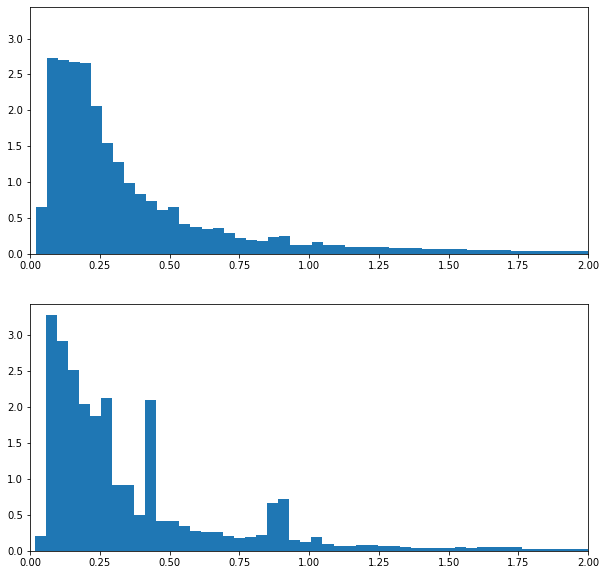

In [204]:
fig, ax = plt.subplots(2,1, figsize = (10,10), sharey=True)
ax[0].set_xlim(0,2)
ax[0].hist(bid_4_3.loc[bid_4_3.bpm < 2, 'bpm'], bins=50, density = True)
ax[1].set_xlim(0,2)
ax[1].hist(bid_4_3.loc[bid_4_3.bpm_4 < 2, 'bpm_4'], bins=50, density = True)

In [67]:
df_bnd = bigquery_client.query(f"""
select
    sp.bundle as sponsored_bnd
    , ho.bundle as hosting_bnd
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , r.country
    , r.exchange_id
    , r.ad_size
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , count(case when event_type = 'install' and vta = TRUE then 1 else NULL end)*16 as vt_installs
    , count(case when event_type = 'install' and vta = FALSE then 1 else NULL end)*16 as ct_installs
    , sum(revenue)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16/1000 as bid
from stats.rows r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and ssb_buyer_id = 3549
    and left(r.id,1) = '0'
group by 1,2,3,4,5,6,7
""").to_dataframe()

In [206]:
df_bnd = df_bnd.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df_bnd['experience_type'] = df_bnd.apply(lambda x:classify_campaigns(x), axis = 1)
df_bnd

exchange_id               sponsored_bnd  \
0                 1         com.facebook.katana   
1                 1      in.playsimple.wordtrip   
2                 1      in.playsimple.wordtrip   
3                 1     com.king.candycrushsaga   
4                 1  com.particlenews.newsbreak   
...             ...                         ...   
621523           59  com.particlenews.newsbreak   
621524           59  com.particlenews.newsbreak   
621525           59  com.particlenews.newsbreak   
621526           59  com.particlenews.newsbreak   
621527           59  com.particlenews.newsbreak   

                              hosting_bnd                 ssb_campaign_uuid  \
0           com.game.crazy.pusher.android  729de681656730b0c02ebd707962aec0   
1                    com.Pizia.VoodooDoll  32306faf44c94f31443228da180c50c7   
2                br.com.tapps.mypastashop  32306faf44c94f31443228da180c50c7   
3                com.lionstudios.mrbullet  f62e397472a0cf3e7633bae892319d97   
4                com.solitairegame.basic2  8e6627e38eabb03d429be94f92c185f5   
...                                   ...                               ...   
621523  com.samsung.android.game.gamehome  50a1b5ac38354aa6f2b023e8e462c883   
621524           com.samsung.android.spay  50a1b5ac38354aa6f2b023e8e462c883   
621525           com.samsung.android.spay  16d935fca4ea8b4dffa296ba147ec7df   
621526          com.sec.android.app.music  16d935fca4ea8b4dffa296ba147ec7df   
621527          com.sec.android.daemonapp  16d935fca4ea8b4dffa296ba147ec7df   

                                            campaign_name country   ad_size  \
0                    SingleTap_FB_ROW_Android_Video_FB_BR      BR  768x1024   
1          DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW      US  768x1024   
2          DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW      US  1024x768   
3                     Android-King-Candy Crush-BR-3-Video      BR  768x1024   
4              Particle Media - News Break - US - USCC PR      US  768x1024   
...                                                   ...     ...       ...   
621523     Particle Media - News Break - US - Tracfone PR      US  768x1024   
621524     Particle Media - News Break - US - Tracfone PR      US       0x0   
621525  Particle Media – News Break – US – All – GP - ...      US       0x0   
621526  Particle Media – News Break – US – All – GP - ...      US       0x0   
621527  Particle Media – News Break – US – All – GP - ...      US       0x0   

        impressions  clicks  installs  vt_installs  ct_installs  spend  \
0              1520      32         0            0            0    0.0   
1              1680     176        32            0            0  108.8   
2                16       0         0            0            0    0.0   
3              9008    1232        16            0            0    4.8   
4               416       0         0            0            0    0.0   
...             ...     ...       ...          ...          ...    ...   
621523          688       0         0            0            0    0.0   
621524           48       0         0            0            0    0.0   
621525       321728    6336       144            0            0  432.0   
621526        64928     512         0            0            0    0.0   
621527          144       0         0            0            0    0.0   

              cost         bid exchange_name  experience_type  
0         2.595587    2.710030         Fyber                2  
1        51.141572   55.401571         Fyber                2  
2         0.269280    0.283514         Fyber                2  
3        13.732509   13.874659         Fyber                3  
4         4.947123   16.827456         Fyber                1  
...            ...         ...           ...              ...  
621523    3.566176    3.558288       Samsung                1  
621524    0.138464    0.138480       Samsung                1  
621525  885.831456  885.546446  

In [207]:
by_bnd = df_bnd.pivot_table(values = 'impressions', index = 'hosting_bnd', columns = 'experience_type', aggfunc = np.sum, margins = True)
sov_by_bnd = 100*by_bnd.div(by_bnd.iloc[-1]).iloc[:-1]
sov_by_bnd.sort_values('All', ascending = False, inplace = True)
top_bnds = sov_by_bnd.sort_values(4, ascending = False).index[:10]
styled_sov_by_bnd = sov_by_bnd.head(50).style.format('{:,.1f}%')
styled_sov_by_bnd = styled_sov_by_bnd.background_gradient(cmap=cm, axis=0)
styled_sov_by_bnd = styled_sov_by_bnd.applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')
styled_sov_by_bnd 

In [208]:
by_bnd = df_bnd.pivot_table(values = 'spend', index = 'hosting_bnd', columns = 'experience_type', aggfunc = np.sum, margins = True)
sov_by_bnd = 100*by_bnd.div(by_bnd.iloc[-1]).iloc[:-1]
sov_by_bnd.sort_values('All', ascending = False, inplace = True)
styled_sov_by_bnd = sov_by_bnd.head(50).style.format('{:,.1f}%')
styled_sov_by_bnd = styled_sov_by_bnd.background_gradient(cmap=cm, axis=0)
styled_sov_by_bnd = styled_sov_by_bnd.applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')
styled_sov_by_bnd 

In [211]:
by_bnd = df_bnd[df_bnd.hosting_bnd.isin(top_bnds)].pivot_table(values = 'spend', index = ['exchange_name','ad_size','hosting_bnd'], columns = 'experience_type', aggfunc = np.sum, margins = True)
sov_by_bnd = 100*by_bnd.div(by_bnd.iloc[-1]).iloc[:-1]
sov_by_bnd.sort_values(['hosting_bnd','All'], ascending = [True, False], inplace = True)
styled_sov_by_bnd = sov_by_bnd[sov_by_bnd.All > 0.05].style.format('{:,.1f}%')
styled_sov_by_bnd = styled_sov_by_bnd.background_gradient(cmap=cm, axis=0)
styled_sov_by_bnd = styled_sov_by_bnd.applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')
styled_sov_by_bnd 

In [209]:
by_size = df_bnd.pivot_table(values = 'impressions', index = 'ad_size', columns = 'experience_type', aggfunc = np.sum, margins = True)
sov_by_size = 100*by_size.div(by_size.iloc[-1]).iloc[:-1]
sov_by_size.sort_values('All', ascending = False, inplace = True)
styled_sov_by_size = sov_by_size.head(50).style.format('{:,.0f}%')
styled_sov_by_size = styled_sov_by_size.background_gradient(cmap=cm, axis=0)
styled_sov_by_size = styled_sov_by_size.applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')
styled_sov_by_size 

In [210]:
by_size = df_bnd.pivot_table(values = 'spend', index = 'ad_size', columns = 'experience_type', aggfunc = np.sum, margins = True)
sov_by_size = 100*by_size.div(by_size.iloc[-1]).iloc[:-1]
sov_by_size.sort_values('All', ascending = False, inplace = True)
styled_sov_by_size = sov_by_size.head(50).style.format('{:,.0f}%')
styled_sov_by_size = styled_sov_by_size.background_gradient(cmap=cm, axis=0)
styled_sov_by_size = styled_sov_by_size.applymap(lambda x:'background-color: white;color: white' if np.isnan(x) else '')
styled_sov_by_size 

# specific examples

In [8]:
df_stats_byday = bigquery_client.query(f"""
select
    sp.bundle as sponsored_bnd
    , ho.bundle as hosting_bnd
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , r.ad_type
    , r.ad_size
    , r.imp_type
    , r.country
    , r.exchange_id
    , date
    , case 
        when ctr_model = 'production' or cr_model = 'production' then 'AP' 
        when ctr_model = 'exploration' or cr_model = 'exploration' then 'media scan'
        else 'ML'
    end as bidder
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , count(case when event_type = 'install' and vta = TRUE then 1 else NULL end) as vt_installs
    , count(case when event_type = 'install' and vta = FALSE then 1 else NULL end) as ct_installs
    , sum(revenue) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
from stats.rows r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
join metadata.apps ho
    on r.hosting_app_id = ho.app_id
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
where 
    date >= '{start_dt}'
    and date <= '2021-05-24'
    and ssb_buyer_id = 3549
group by 1,2,3,4,5,6,7,8,9,10,11

union all

select
    sp.bundle as sponsored_bnd
    , ho.bundle as hosting_bnd
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , r.ad_type
    , r.ad_size
    , r.imp_type
    , r.country
    , r.exchange_id
    , date
    , case 
        when ctr_model = 'production' or cr_model = 'production' then 'AP' 
        when ctr_model = 'exploration' or cr_model = 'exploration' then 'media scan'
        else 'ML'
    end as bidder
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , count(case when event_type = 'install' and vta = TRUE then 1 else NULL end) as vt_installs
    , count(case when event_type = 'install' and vta = FALSE then 1 else NULL end) as ct_installs
    , sum(revenue) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
from stats.rows1 r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
join metadata.apps ho
    on r.hosting_app_id = ho.app_id
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
where 
    date >= date(greatest('2021-05-25','{start_dt}'))
    and date <= '{end_dt}'
    and ssb_buyer_id = 3549
group by 1,2,3,4,5,6,7,8,9,10,11
""").to_dataframe()

In [9]:
df_stats_byday = df_stats_byday.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df_stats_byday = df_stats_byday.set_index('imp_type').join(imp_type.set_index('imp_type_id')).reset_index()

In [12]:
df_stats_byday['experience_type'] = df_stats_byday.apply(lambda x:classify_campaigns(x), axis = 1)

In [13]:
exp4_byday = df_stats_byday[df_stats_byday.experience_type == 4]

In [14]:
exp4_byday.groupby('campaign_name')['spend'].sum().sort_values()

campaign_name
Android-King-Candy Crush-BR-4-Display            28.50
Beach Bum-Spade Royale-US-4                      37.50
Android-King-Candy Crush-US-4-Display           180.00
Huuuge Games-Billionaire Casino Slots-US-4      217.00
Android-King-Candy Crush-BR-4-Video             280.80
Android-Twitter-Twitter-SG-4                    335.10
Android-Twitter-Twitter-SA-4                    399.20
TikTok - TikTok - MX - True GP                  579.00
Android-Wish-Wish-US-4                          582.00
Android-Opera Norway As-Opera News-DE-4         696.00
Position Mobile-WeatherHome-US-4                812.10
Android-Twitter-Twitter-CL-4                   1139.20
Android-Opera Norway As-Opera News-FR-4        1192.00
Android-Twitter-Twitter-CA-4                   1425.80
Android-Twitter-Twitter-PT-4                   1506.80
Android-Twitter-Twitter-KR-4                   1544.50
Particle Media-News Break-US-iOS               1641.50
Android-Twitter-Twitter-AU-4                   1653

In [212]:
i = ['date']
pivot = exp4_byday[exp4_byday.campaign_name == 'Android-Door Dash-Door Dash-US- 4'].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'date')
pivot.sort_values('date')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','cost','spend','sov','margin']
color_format(pivot[cols], format_mapping, ['date', 'sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-16-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)


In [18]:
i = ['campaign_name','hosting_bnd']
pivot = exp4_byday[exp4_byday.campaign_name == 'Android-Door Dash-Door Dash-US- 4'].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
pivot.sort_values('campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
color_format(pivot[cols].head(20), format_mapping, ['campaign_name', 'sov'])


In [58]:
i = ['hosting_bnd','ad_size','date', 'exchange_name']
filters = (exp4_byday.campaign_name == 'Android-Door Dash-Door Dash-US- 4') & (exp4_byday.hosting_bnd == 'com.vaart.cryptoinfo') & (exp4_byday.ad_size == '300x250')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'date')
pivot.sort_values('date')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
color_format(pivot[cols], format_mapping, ['date', 'sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-16-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax +

In [214]:
i = ['campaign_name','ad_size','hosting_bnd']
filters = (exp4_byday.campaign_name == 'Android-Door Dash-Door Dash-US- 4')&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
pivot.sort_values('campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','cost','spend','sov','margin']
color_format(pivot[cols].head(20), format_mapping, ['campaign_name', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [213]:
i = ['hosting_bnd','ad_size','date']
bnds = ['com.enflick.android.TextNow']
filters = (exp4_byday.campaign_name == 'Android-Door Dash-Door Dash-US- 4') & (exp4_byday.hosting_bnd.isin(bnds)) & (exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','spend','cost','bid'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'date')
pivot.sort_values('date')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','cost','spend','sov','margin']
color_format(pivot[cols], format_mapping, ['hosting_bnd','ad_size','date', 'sov'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-16-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax +

In [222]:
dd = df_stats_byday[df_stats_byday.sponsored_bnd == 'com.dd.doordash']
pvt = dd.pivot_table(values = 'cost', index = ['ad_size'], columns = 'experience_type', aggfunc = np.sum, margins = True)
sov = 100*pvt.div(pvt.iloc[-1])
sov.sort_values('All', ascending = False, inplace = True)
sov.iloc[1:42].style.format('{:,.1f}%').background_gradient(cmap = cm)


In [240]:
dd = df_stats_byday[df_stats_byday.sponsored_bnd == 'com.dd.doordash']
pvt = dd.pivot_table(values = 'cost', index = ['hosting_bnd'], columns = 'experience_type', aggfunc = np.sum, margins = True)
sov = 100*pvt.div(pvt.iloc[-1])
sov.sort_values('All', ascending = False, inplace = True)
sov.iloc[1:42].style.format('{:,.1f}%').background_gradient(cmap = cm)


Overlap between different experiences of DoorDash is decently high, though this is challenging to quantify.

In [22]:
i = ['campaign_name','exchange_name']
filters = (exp4_byday.campaign_name == 'Android-Door Dash-Door Dash-US- 4') #&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
color_format(pivot[cols].head(20), format_mapping, ['campaign_name', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [23]:
exp4_byday[(exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4'))].groupby('date')['impressions','clicks','installs','spend'].sum()

<ipython-input-23-5f798724d51e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  exp4_byday[(exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4'))].groupby('date')['impressions','clicks','installs','spend'].sum()


impressions  clicks  installs  spend
date                                            
2021-05-14        10371    1073         3    9.0
2021-05-15       142149    6293        19   57.0
2021-05-16       116896    2913        14   54.0
2021-05-17       347954   13976        47  144.0
2021-05-18       599477   20303        40  120.0
2021-05-19       348344   13075        38  129.0
2021-05-20        62187    1420         7   21.0
2021-05-21        57841    1154         7   21.0
2021-05-22        88476    3222        21   69.0
2021-05-23        80733    2822        11   33.0
2021-05-24        57705    2577        13   42.0
2021-05-25        61548    2354        11   33.0
2021-05-26        62509    2403        14   51.0
2021-05-27        77502    2674        18   54.0
2021-05-28        74321    2932        23   87.0
2021-05-29        48771    1873        14   42.0
2021-05-30        43607    1511        16   48.0
2021-05-31        70664    1535        13   39.0
2021-06-01        70960    1889        15   45.0
2021-06-02        87784    2914        17   56.0
2021-06-03       126055    6627        49  260.0
2021-06-04       150669   12989        63  289.0
2021-06-05       141910   15826        83  348.0
2021-06-06       103379   10908        75  322.0
2021-06-07        45903    3891        42  190.0
2021-06-08        65909    5877        62  324.0
2021-06-09       103304    9218        81  400.0
2021-06-10       157331   15188       148  632.0
2021-06-11       168342   17860       163  744.0
2021-06-12       104878   11420       150  760.0
2021-06-13       158229   17289       162  812.0

In [232]:
i = ['date']
filters = (exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4')) #&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','cost','spend','sov','margin']
color_format(pivot[cols], format_mapping, ['date', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-16-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)


In [236]:
i = ['date']
filters = (exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4')) #&(exp4_byday.ad_size.isin(['768x1024','1024x768']))
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','cost','spend','sov','margin']
color_format(pivot[cols], format_mapping, ['date', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-16-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)


In [237]:
i = ['campaign_name','hosting_bnd']
filters = (exp4_byday.campaign_name == 'Android-King-Candy Crush-US-4-Video') #&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
top_bnds = pivot.sort_values('cost', ascending = False).index.get_level_values(1).to_list()[:10]
color_format(pivot[cols].head(25), format_mapping, ['campaign_name', 'cost'])


In [51]:
i = ['campaign_name','exchange_name']
filters = (exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4')) #&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
color_format(pivot[cols].head(20), format_mapping, ['campaign_name', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [52]:
i = ['campaign_name','ad_size']
filters = (exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4')) #&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
color_format(pivot[cols].head(20), format_mapping, ['campaign_name', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [53]:
i = ['campaign_name','impression type', 'ad_size']
filters = (exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4')) #&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
color_format(pivot[cols].head(20), format_mapping, ['campaign_name', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [55]:
i = ['campaign_name','date','exchange_name','hosting_bnd']
filters = (exp4_byday.campaign_name == 'Android-King-Candy Crush-US-4-Video') &(exp4_byday.hosting_bnd.isin(top_bnds))
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','cost','spend','sov','margin']
color_format(pivot[cols], format_mapping, ['campaign_name','exchange_name','hosting_bnd','date', 'sov'])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-16-d08c1dc7f9f0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.sort_values(sort_order, ascending = [True]*(len(sort_order)-1) + [False], inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax +

In [47]:
i = ['campaign_name','bidder']
filters = (exp4_byday.campaign_name.str.startswith('Android-King-Candy Crush-US-4')) #&(exp4_byday.ad_size == '320x50')
pivot = exp4_byday[filters].pivot_table(values = ['impressions','clicks','installs','bid','cost','spend'], index = i, aggfunc = np.sum)
calc_metrics(pivot, 'campaign_name')
cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','cost','spend','sov','margin']
color_format(pivot[cols].head(20), format_mapping, ['campaign_name', 'sov'])


In [238]:
cc = df_stats_byday[df_stats_byday.sponsored_bnd == 'com.king.candycrushsaga']
pvt = cc.pivot_table(values = 'impressions', index = ['ad_size'], columns = 'experience_type', aggfunc = np.sum, margins = True)
sov = 100*pvt.div(pvt.iloc[-1])
sov.sort_values('All', ascending = False, inplace = True)
sov.iloc[1:42].style.format('{:,.1f}%').background_gradient(cmap = cm)


In [239]:
cc = df_stats_byday[df_stats_byday.sponsored_bnd == 'com.king.candycrushsaga']
pvt = cc.pivot_table(values = 'impressions', index = ['ad_size','hosting_bnd'], columns = 'experience_type', aggfunc = np.sum, margins = True)
sov = 100*pvt.div(pvt.iloc[-1])
sov.sort_values('All', ascending = False, inplace = True)
sov.iloc[1:42].style.format('{:,.1f}%').background_gradient(cmap = cm)


Overlap between different experiences of DoorDash is decently high, though this is challenging to quantify.

In [15]:
# Look for concentrations of organic installs/purchases on apps ->
df_organic = bigquery_client.query(f"""
select
    ifa
    , ename
    , etype
    , bundle
from `ext_data.RTB202104*`
where 
    bundle in ('com.king.candycrushsaga','com.dd.doordash')
group by 1,2,3,4

union all

select
    ifa
    , ename
    , etype
    , bundle
from `ext_data.RTB202105*`
where 
    bundle in ('com.king.candycrushsaga','com.dd.doordash')
group by 1,2,3,4

union all

select
    ifa
    , ename
    , etype
    , bundle
from `ext_data.RTB202106*`
where 
    bundle in ('com.king.candycrushsaga','com.dd.doordash')
group by 1,2,3,4
""").to_dataframe()


In [16]:
df_organic['ifa'].to_csv('~/Downloads/organic_users.csv', index = False, header = False)
!ruby ~/Documents/appreciate/ifas_to_tids.rb ~/Downloads/organic_users.csv ~/Downloads/hashed_organic_users.txt
hashed_tids = pd.read_table('~/Downloads/hashed_organic_users.txt', header = None, names = ['tid'])
df_organic = df_organic.join(hashed_tids)
df_organic

ifa ename    etype  \
0        3ae13697-ed6f-40e8-adce-cd107faab787  None  install   
1        351b281d-4559-4f53-bc6f-6a08d135bf49  None  install   
2        87db2192-1faa-4998-80b6-5e695aef236b  None  install   
3        7a03814f-a152-4b25-9fe5-bf46df7d78ad  None  install   
4        03895279-ccdc-411d-856e-f5e89ae1faf7  None  install   
...                                       ...   ...      ...   
2897732  efd52bbc-4b5a-42e5-a9fc-6b23938abbfb  None  install   
2897733  93f7dce9-e6f0-4144-b7e8-ca9924c8cc4e  None  install   
2897734  fcf388d1-01fb-438d-a660-f5bc424a10e2  None  install   
2897735  f241b000-d93a-4e69-ae7b-085474125e64  None  install   
2897736  898aae21-4b6f-460d-a44b-89ecbfdb7e70  None  install   

                          bundle                               tid  
0        com.king.candycrushsaga  32982e587560ac1faa644c420c5af405  
1        com.king.candycrushsaga  1198e6ec7a8b8bcf9141df37976e5475  
2        com.king.candycrushsaga  f78d7271b2b4e6e02dd3e1908559c356  
3        com.king.candycrushsaga  1429ba9ac3f221287a88e78cb45bd5b1  
4        com.king.candycrushsaga  20023640d46c80168d6f225140c38057  
...                          ...                               ...  
2897732          com.dd.doordash  856046b316c9f3d915224f1827a215f7  
2897733          com.dd.doordash  a2cd3960417958b199a59cfe5fe724de  
2897734          com.dd.doordash  c1700626dfcd6c43edadabaf58923619  
2897735          com.dd.doordash  dfcbfda4e67c755032f41bdf1cc63e36  
2897736          com.dd.doordash  3b5f299ab9fc97fb61edfd43c928ed1a  

[2897737 rows x 5 columns]

In [ ]:
df_list = []
for i in range(1+int(df_organic.shape[0]/10000)):
    range_start = i*10000
    range_end = min(df_organic.shape[0],(i+1)*10000)
    device_id_list = tuple(df_organic.iloc[range_start:range_end, 4])
    print(f'Running query {i} of {int(df_organic.shape[0]/10000)}')

    df_sub = bigquery_client.query(f"""
    select
        tid
        , p.bundle
        , p.name
    from stats.rows1 r
    join metadata.apps p
        on r.hosting_app_id = p.app_id
    where
        date >= '{start_dt}'
        and date <= '{end_dt}'
        and event_type = 'clear'
        and tid in {device_id_list}
    group by 1,2,3
    """).to_dataframe()
    df_list.append(df_sub)


Running query 0 of 289
Running query 1 of 289
Running query 2 of 289
Running query 3 of 289
Running query 4 of 289
Running query 5 of 289
Running query 6 of 289
Running query 7 of 289
Running query 8 of 289
Running query 9 of 289
Running query 10 of 289
Running query 11 of 289
Running query 12 of 289
Running query 13 of 289
Running query 14 of 289
Running query 15 of 289
Running query 16 of 289
Running query 17 of 289
Running query 18 of 289
Running query 19 of 289
Running query 20 of 289
Running query 21 of 289
Running query 22 of 289
Running query 23 of 289
Running query 24 of 289
Running query 25 of 289
Running query 26 of 289
Running query 27 of 289
Running query 28 of 289
Running query 29 of 289
Running query 30 of 289
Running query 31 of 289
Running query 32 of 289
Running query 33 of 289
Running query 34 of 289
Running query 35 of 289
Running query 36 of 289
Running query 37 of 289
Running query 38 of 289
Running query 39 of 289
Running query 40 of 289
Running query 41 of 289
Ru

In [ ]:
df_overlap = pd.concat(df_list)

dd_organic = df_organic.loc[df_organic.bundle == 'com.dd.doordash', ['tid','etype']].drop_duplicates().set_index('tid')
dd_organic.columns = ['dd_users']
ccs_organic = df_organic.loc[df_organic.bundle == 'com.king.candycrushsaga', ['tid','etype']].drop_duplicates().set_index('tid')
ccs_organic.columns = ['ccs_users']

df_overlap = df_overlap.set_index('tid').join(dd_organic, how = 'left', rsuffix = '_dd')
df_overlap = df_overlap.join(ccs_organic, how = 'left', rsuffix = '_ccs')
overlap_by_bnd = df_overlap.pivot_table(values = ['dd_users','ccs_users'], index = 'bundle', aggfunc = 'count')
overlap_by_bnd

In [ ]:
df_totals_by_bnd = bigquery_client.query(f"""
    select
        p.bundle
        , p.name
        , 16*count(distinct tid) as total_users
    from stats.rows1 r
    join metadata.apps p
        on r.hosting_app_id = p.app_id
    where
        date >= '{start_dt}'
        and date <= '{end_dt}'
        and event_type = 'clear'
        and left(tid,1) = '0'
    group by 1,2
    """).to_dataframe()

In [ ]:
df_compare_by_bnd = df_totals_by_bnd.set_index('bundle').join(overlap_by_bnd, how = 'left')
df_compare_by_bnd[['ccs_users','dd_users']] = df_compare_by_bnd[['ccs_users','dd_users']].fillna(0)
df_compare_by_bnd['ccs_pct'] = 100*df_compare_by_bnd['ccs_users']/df_compare_by_bnd['total_users']
df_compare_by_bnd['dd_pct'] = 100*df_compare_by_bnd['dd_users']/df_compare_by_bnd['total_users']
df_compare_by_bnd = df_compare_by_bnd.reset_index().set_index(['bundle','name'])
df_compare_by_bnd = df_compare_by_bnd.loc[(df_compare_by_bnd.ccs_users + df_compare_by_bnd.dd_users).sort_values(ascending = False).index]

format_map = {'total_users':'{:,.0f}'
             ,'ccs_users':'{:,.0f}'
             ,'dd_users':'{:,.0f}'
             ,'ccs_pct':'{:,.1f}%'
             ,'dd_pct':'{:,.1f}%'}
df_compare_by_bnd.head(40).style.format(format_map).background_gradient(cmap=cm)

In [ ]:
df_compare_by_bnd.sort_values('dd_users', ascending = False, inplace = True)

fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].hist(df_compare_by_bnd.iloc[:1000,4], bins = 30, weights=np.ones(1000) / 1000)
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].set_title('Distr. of the percentage of publisher\'s users have DD installs')
df_compare_by_bnd.sort_values('ccs_users', ascending = False, inplace = True)

ax[1].hist(df_compare_by_bnd.iloc[:1000,3], bins = 30, weights=np.ones(1000) / 1000)
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1].set_title('Distr. of the percentage of publisher\'s users have CCS installs')

In [ ]:
dd_top_pubs = df_compare_by_bnd.loc[df_compare_by_bnd.dd_pct > 1, ['total_users','dd_users','dd_pct']]
dd_top_pubs.sort_values('dd_users', ascending = False, inplace = True)

format_map = {'total_users':'{:,.0f}'
             ,'ccs_users':'{:,.0f}'
             ,'dd_users':'{:,.0f}'
             ,'ccs_pct':'{:,.1f}%'
             ,'dd_pct':'{:,.1f}%'}
dd_top_pubs.to_csv(f'~/Downloads/DD_pub_overlap_{start_dt}_{end_dt}.csv')
dd_top_pubs.head(20).style.format(format_map).background_gradient(cmap=cm)

In [ ]:
ccs_top_pubs = df_compare_by_bnd.loc[df_compare_by_bnd.ccs_pct > 0.5, ['total_users','ccs_users','ccs_pct']]
ccs_top_pubs.sort_values('ccs_users', ascending = False, inplace = True)

format_map = {'total_users':'{:,.0f}'
             ,'ccs_users':'{:,.0f}'
             ,'dd_users':'{:,.0f}'
             ,'ccs_pct':'{:,.1f}%'
             ,'dd_pct':'{:,.1f}%'}
ccs_top_pubs.to_csv(f'~/Downloads/CCS_pub_overlap_{start_dt}_{end_dt}.csv')
ccs_top_pubs.head(20).style.format(format_map).background_gradient(cmap=cm)